In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import re
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

In [2]:
df = pd.read_csv('pharmodel_v4.csv')

In [3]:
df.head()

,Unnamed: 0,asin,cat,rating,reviews,price,vp,fsa_flg,eff_max_str,eff_fast_acting,...,inch_q_10,inch_q_20,inch_q_30,weight_q_00,weight_q_10,weight_q_20,weight_q_30,vp_cat,vp_cat2,vp_cat3
0,0,B07BQKPMFM,cold,4.7,11523,12.74,0.368917,1,1,0,...,0,1,0,0,0,1,0,1,0,1
1,1,B009ITR4EY,cold,4.8,26392,7.66,0.626632,1,1,0,...,0,0,0,0,1,0,0,1,1,1
2,2,B013Q8JZVM,cold,4.8,1389,15.34,0.312907,1,1,1,...,0,1,0,0,1,0,0,1,0,0
3,3,B074F297S8,cold,4.7,10169,7.99,0.588235,1,0,0,...,0,0,1,0,0,0,1,1,1,1
4,4,B011VX2FGQ,cold,4.7,3448,12.98,0.362096,1,1,0,...,0,0,1,0,0,0,1,1,0,1


In [4]:
df.columns[:10]

Index(['Unnamed: 0', 'asin', 'cat', 'rating', 'reviews', 'price', 'vp',
       'fsa_flg', 'eff_max_str', 'eff_fast_acting'],
      dtype='object')

In [5]:
df.cat.value_counts()

cold    451
dig     366
alg     352
pain    276
Name: cat, dtype: int64

In [6]:
df['y_class'] = df['vp_cat3']

In [7]:
X_features = ['fsa_flg', 'eff_max_str', 'eff_fast_acting', 'eff_long_lasting',
       'eff_non_drowsy', 'eff_kid', 'ingre_zinc', 'ingre_simethicone', 'ingre_pulsatilla',
       'ingre_phosphorus', 'ingre_phenylephrine', 'ingre_perfoliatum',
       'ingre_peppermint', 'ingre_omeprazole', 'ingre_naproxen',
       'ingre_menthol', 'ingre_magnesium', 'ingre_loratadine', 'ingre_kali',
       'ingre_ipecacuanha', 'ingre_ibuprofen', 'ingre_hydrobromide',
       'ingre_guaifenesin', 'ingre_gelsemium', 'ingre_fexofenadine',
       'ingre_famotidine', 'ingre_eupatorium', 'ingre_eucalyptus',
       'ingre_esomeprazole', 'ingre_echinacea', 'ingre_doxylamine',
       'ingre_diphenhydramine', 'ingre_dextromethorphan',
       'ingre_chlorpheniramine', 'ingre_cetirizine', 'ingre_calcium',
       'ingre_bryonia', 'ingre_antihistamine', 'ingre_aluminum',
       'ingre_acetaminophen', 'brand_zyrtec', 'brand_zicam',
       'brand_zegerid_otc', 'brand_vicks', 'brand_tylenol', 'brand_tums',
       'brand_time_cap_labs_inc', 'brand_theraflu', 'brand_rolaids',
       'brand_rite_aid', 'brand_quality_choice', 'brand_prilosec',
       'brand_prelief', 'brand_pepto_bismol', 'brand_pepcid', 'brand_nexium',
       'brand_natures_way', 'brand_mylanta', 'brand_mucinex', 'brand_motrin',
       'brand_midol', 'brand_major', 'brand_hylands', 'brand_goodsense',
       'brand_gaviscon', 'brand_flonase', 'brand_excedrin',
       'brand_coricidin_hbp', 'brand_claritin', 'brand_chloraseptic',
       'brand_boiron', 'brand_benadryl', 'brand_amazon_basic_care',
       'brand_allegra', 'brand_alka_seltzer_plus', 'brand_alka_seltzer',
       'brand_aleve', 'brand_airborne', 'brand_advil', 'brand_a2z_store',
       'manu_gsk', 'manu_jj', 'manu_bayer', 'manu_rb', 'manu_perrigo',
       'manu_pg', 'manu_sanofi', 'manu_ama', 'manu_major', 'manu_rite',
       'manu_boiron', 'manu_pfizer', 'manu_hyland', 'manu_alka',
       'manu_allegiant', 'manu_prestige', 'manu_dwight', 'manu_emc', 'manu_nw',
       'manu_walmart', 'manu_kirkland', 'manu_ohm', 'manu_reddy',
       'manu_bionpharma', 'manu_time', 'count_q_00', 'count_q_10',
       'count_q_20', 'count_q_30', 'inch_q_00', 'inch_q_10', 'inch_q_20',
       'inch_q_30', 'weight_q_00', 'weight_q_10', 'weight_q_20', 'weight_q_30']

In [8]:
data = df[df.cat=='cold'][X_features+['y_class','vp', 'cat', 'asin', 'rating', 'reviews', 'price']]

In [9]:
data.y_class.value_counts()

0    226
1    225
Name: y_class, dtype: int64

In [10]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV,  cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, make_scorer
from sklearn.pipeline import Pipeline
import numpy as np

# Load dataset and split into training, validation, and testing sets

X_train, y_train, z = data[X_features], data['y_class'], data['vp']
# X_train, X_test, y_train, y_test, z_train, z_test = train_test_split(X, y, z, test_size=0.2, random_state=42, stratify=y)


# Define models
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'MLP': MLPClassifier(early_stopping=True, max_iter=1000,random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42),
    'Gaussian NB': GaussianNB(),
    'KNN': KNeighborsClassifier(),
    'LDA': LinearDiscriminantAnalysis()
}

# Hyperparameters for grid search
param_grids = {
    'Random Forest': {
        'classifier__n_estimators': [50, 100, 200,300],
        'classifier__max_depth': [None, 10, 20, 30],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__bootstrap':[True,False]
    }
     ,
    'XGBoost': {
        'classifier__learning_rate': [0.01, 0.05, 0.1],
        'classifier__n_estimators': [100, 200,300],
        'classifier__max_depth': [3, 5, 7],
    },
    'MLP': {
        'classifier__hidden_layer_sizes': [(50,), (100,), (50, 50)],
        'classifier__activation': ['relu', 'tanh'],
        'classifier__solver': ['adam', 'sgd'],
    }
}

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score, needs_proba=True)
}

for name, model in models.items():
    print(f"===== {name} =====")
    
    pipeline = Pipeline([
        ('classifier', model)
    ])
    
    # If the model has hyperparameters to tune, apply GridSearchCV
    if name in param_grids:
        grid_search = GridSearchCV(pipeline, param_grids[name], cv=5, n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_pipeline = grid_search.best_estimator_
#         if name == 'Random Forest':
#             rf_model = best_pipeline
        # Output the best hyperparameters for each model
        print(f"Best hyperparameters for {name}: {grid_search.best_params_}")
    else:
        best_pipeline = pipeline
        best_pipeline.fit(X_train, y_train)
    
    if name == 'Random Forest':
        rf_model = best_pipeline
    if name == 'XGBoost':
        gb_model = best_pipeline
    if name == 'LDA':
        lda_model = best_pipeline
    if name == 'Logistic Regression':
        lr_model = best_pipeline
    
    # Cross-Validation metrics
    cv_results = cross_validate(best_pipeline, X_train, y_train, cv=5, scoring=scoring)
    
    for metric in scoring.keys():
        mean_metric = np.mean(cv_results[f'test_{metric}'])
        std_metric = np.std(cv_results[f'test_{metric}'])
        print(cv_results[f'test_{metric}'],f"{metric.capitalize()}: {mean_metric:.4f} ± {std_metric:.4f}")

        
    print()

===== Logistic Regression =====
[0.65934066 0.7        0.66666667 0.7        0.46666667] Accuracy: 0.6385 ± 0.0875
[0.60606061 0.66666667 0.68292683 0.78125    0.4516129 ] Precision: 0.6377 ± 0.1087
[0.88888889 0.8        0.62222222 0.55555556 0.31111111] Recall: 0.6356 ± 0.2015
[0.72072072 0.72727273 0.65116279 0.64935065 0.36842105] F1: 0.6234 ± 0.1317
[0.65410628 0.78567901 0.73679012 0.7508642  0.53506173] Roc_auc: 0.6925 ± 0.0898

===== Decision Tree =====
[0.59340659 0.67777778 0.7        0.68888889 0.64444444] Accuracy: 0.6609 ± 0.0385
[0.57692308 0.68181818 0.70454545 0.72972973 0.70967742] Precision: 0.6805 ± 0.0540
[0.66666667 0.66666667 0.68888889 0.6        0.48888889] Recall: 0.6222 ± 0.0730
[0.6185567  0.6741573  0.69662921 0.65853659 0.57894737] F1: 0.6454 ± 0.0419
[0.59637681 0.67037037 0.68864198 0.66469136 0.66716049] Roc_auc: 0.6574 ± 0.0317

===== MLP =====
Best hyperparameters for MLP: {'classifier__activation': 'tanh', 'classifier__hidden_layer_sizes': (50, 50), '

In [11]:
#best_pipeline

# Variable importance

In [12]:
## 1shap

In [13]:
#pip install shap

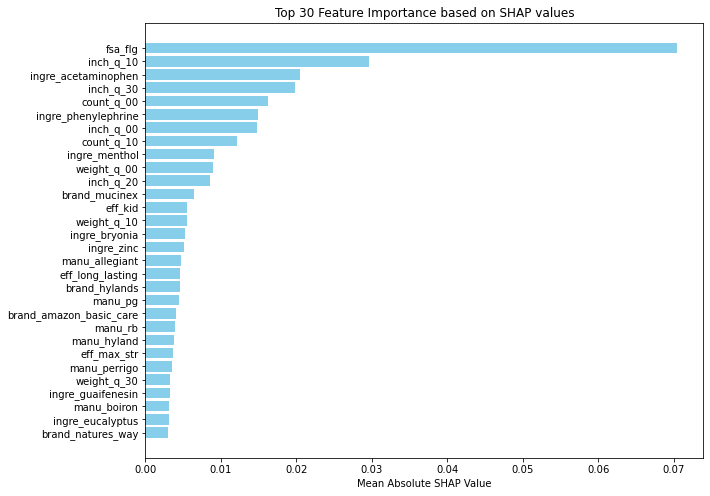

In [14]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# Create a SHAP explainer object
explainer = shap.TreeExplainer(rf_model.named_steps['classifier'])
shap_values = explainer.shap_values(X_train)

# Calculate absolute mean SHAP values
mean_abs_shap_values = np.mean(np.abs(shap_values[1]), axis=0)  # Considering only the positive class

# Get feature names
feature_names = X_train.columns  # Assuming X_train is a pandas DataFrame

# Get indices of top 30 features sorted by absolute SHAP values
top_indices = np.argsort(mean_abs_shap_values)[::-1][:30]

# Select top 30 feature names and corresponding mean absolute SHAP values
top_feature_names = [feature_names[i] for i in top_indices]
top_mean_abs_shap_values = mean_abs_shap_values[top_indices]

# Create a bar chart
plt.figure(figsize=(10, 8))
plt.barh(range(len(top_feature_names)), top_mean_abs_shap_values, align='center', color='skyblue')
plt.yticks(range(len(top_feature_names)), top_feature_names)
plt.xlabel('Mean Absolute SHAP Value')
plt.title('Top 30 Feature Importance based on SHAP values')
plt.gca().invert_yaxis()  # Invert y-axis to display the most important features at the top
plt.show()

In [15]:
#np.quantile(mean_abs_shap_values,0.7)

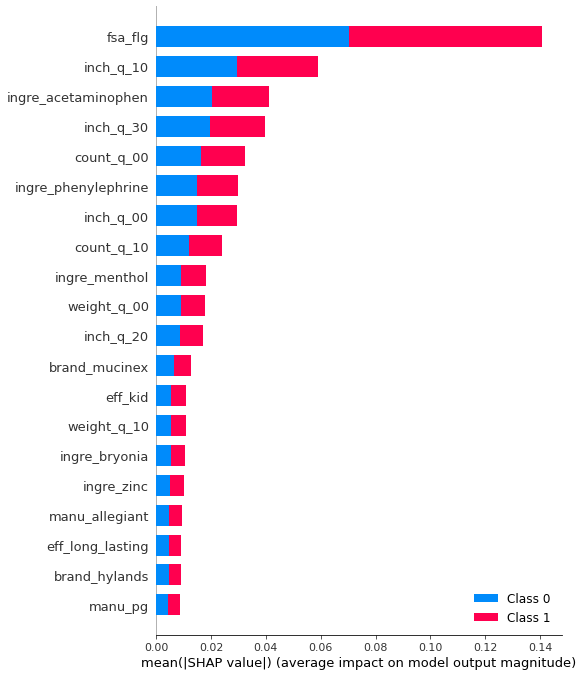

In [16]:
import shap
import matplotlib.pyplot as plt

# Assuming you have already calculated SHAP values and defined the explainer
# Create a summary plot
shap.summary_plot(shap_values, X_train, plot_type="bar", show=False)

# Show the plot
plt.show()

In [17]:
# import pandas as pd
# import matplotlib.pyplot as plt

# # Access feature importances from the Random Forest model
# feature_importances = rf_model.named_steps['classifier'].feature_importances_

# # Create a DataFrame to store feature importances
# feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

# # Sort the DataFrame by Importance in descending order
# feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)

# # Output the top 30 features
# top_30_features = feature_importance_df.head(25)
# print(top_30_features)

# # Plot feature importances
# plt.figure(figsize=(10, 6))
# plt.barh(top_30_features['Feature'], top_30_features['Importance'])
# plt.xlabel('Feature Importance')
# plt.ylabel('Feature')
# plt.title('Top 30 Feature Importance from Random Forest Model')
# plt.show()

In [18]:
## logistic regression feat importance

In [19]:
import pandas as pd

# Extract coefficient estimates
coefficients = lr_model.named_steps['classifier'].coef_[0]

# Calculate p-values (not directly available in scikit-learn)
# You would typically use statsmodels for p-values with logistic regression

# Create a DataFrame to store coefficients and p-values
variable_info = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': coefficients})

# Calculate absolute coefficients
variable_info['Absolute Coefficient'] = abs(variable_info['Coefficient'])

# Sort variables based on absolute coefficient values
variable_info.sort_values(by='Absolute Coefficient', ascending=False, inplace=True)

# You should determine statistical significance based on your chosen method
# Since we don't have p-values directly, you might need to use other statistical tools
# For demonstration purposes, I'm assuming all coefficients are statistically significant
variable_info['Significance'] = True

# Print the ranked variables and their statistical significance
#print(variable_info[:20])

In [20]:
import pandas as pd

# Assuming you have a DataFrame named 'top_feature_names' containing the names of the top features
# and another DataFrame named 'variable_info' containing information about all features

# Filter variable_info to include only rows where the Feature is in top_feature_names
filtered_variable_info = variable_info[variable_info['Feature'].isin(top_feature_names)]

# Order filtered_variable_info by the top_feature_names list
ordered_variable_info = filtered_variable_info.set_index('Feature').loc[top_feature_names].reset_index()
ordered_variable_info

,Feature,Coefficient,Absolute Coefficient,Significance
0,fsa_flg,1.063547,1.063547,True
1,inch_q_10,1.005730,1.005730,True
2,ingre_acetaminophen,0.404444,0.404444,True
3,inch_q_30,-0.869138,0.869138,True
4,count_q_00,0.506743,0.506743,True
5,ingre_phenylephrine,0.489982,0.489982,True
6,inch_q_00,0.982191,0.982191,True
7,count_q_10,-1.028191,1.028191,True
8,ingre_menthol,1.233159,1.233159,True
9,weight_q_00,0.422964,0.422964,True
